# Bitcoin transaction graph


In [21]:
import os

import json
from pprint import pprint

import requests
import requests_cache

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx

from hiveplot import HivePlot

from node2vec import node2vec as n2v


plt.style.use('ggplot')
%matplotlib inline

pd.set_option("display.max_columns",100)

In [4]:
BASE_URL = "https://blockchain.info/"
TIMEOUT = 10

T_GENESIS =1231006505000
ms_per_day = 1000*60*60*24

# Set path of file for caching API calls
requests_cache.install_cache('../bci')

## Query by block height

In [38]:
def get_blockchain(max_height, min_height=0, 
                   base_url = "https://blockchain.info/",
                   timeout = 30, payload=None, verbose=False):
    """
    Query blockchain.info API and return list of block JSONs between (inclusive)
    min and max heights
    """
    block_list = []
    for height in range(min_height, max_height+1):
        if verbose and height % 500 == 0:
            print("Reading block {0}".format(height))
        resource = 'block-height/{0}?format=json'.format(height)
        response_content = requests.get(base_url + resource, payload, timeout=timeout).content
        
        block_list.append(json.loads(response_content)['blocks'])
    
    # Flatten the list
    block_list_flat = [item for sublist in block_list for item in sublist]
    
    return block_list_flat


def blocks2df(block_list, cols = None):
    """
    Parse the flat list of blocks to a dataframe, with one row per transaction
    """
    tx_in_list = []
    tx_out_list = []
    tx_in_dfs = []
    tx_out_dfs = []
    #for block in [block_list_flat[multi] for multi in mts]:
    for block in block_list:
        height = block['height']
        for i_tx in range(block['n_tx']):
            tx_hash = block['tx'][i_tx]['hash']
            for in_dict in block['tx'][i_tx]['inputs']:

                if 'prev_out' in in_dict.keys():
                    prev_out_dict = {}
                    for key, val in in_dict['prev_out'].items():
                        prev_out_dict['prev_' + key] = val
                    prev_out_dict = {**{'height': height, 'tx_hash': tx_hash}, **prev_out_dict}
                    tx_in_list.append(prev_out_dict)

                else:
                    tx_in_dict = {**{'height': height, 'tx_hash': tx_hash}, **in_dict}
                    tx_in_list.append(tx_in_dict)

            for out_dict in block['tx'][i_tx]['out']:
                tx_out_dicts = {**{'height': height, 'tx_hash': tx_hash}, **out_dict}
                tx_out_list.append(tx_out_dicts)
    tx_in_df = pd.DataFrame(tx_in_list)
    tx_out_df = pd.DataFrame(tx_out_list)
    
    block_df = pd.merge(tx_out_df, tx_in_df, on = ['tx_hash', 'height'], how = 'outer')
    if cols is None:
        return block_df
    else:
        return block_df[[c for c, _ in cols]].rename(columns = dict(cols))
        

In [39]:
block_list = get_blockchain(501, verbose = True)
col_dict = [('addr', 'addr_to'),
       ('prev_addr', 'addr_from'),
        ('height', 'height'),
        ('script_x', 'script_out'),
        ('script_y', 'script_in'),
       ('spent', 'spent_flag'),
       ('value', 'value')]


block_df = blocks2df(block_list, cols)
print(block_df.shape)
block_df.head()

Reading block 0
Reading block 500
(517, 7)


,addr_to,addr_from,height,script_out,script_in,spent_flag,value
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,NaN,0,4104678afdb0fe5548271967f1a67130b7105cd6a828e0...,04ffff001d0104455468652054696d65732030332f4a61...,False,5000000000
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,NaN,1,410496b538e853519c726a2c91e61ec11600ae1390813a...,04ffff001d0104,False,5000000000
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,NaN,2,41047211a824f55b505228e4c3d5194c1fcfaa15a456ab...,04ffff001d010b,False,5000000000
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,NaN,3,410494b9d3e76c5b1629ecf97fff95d7a4bbdac87cc260...,04ffff001d010e,False,5000000000
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,NaN,4,4104184f32b212815c6e522e66686324030ff7e5bf08ef...,04ffff001d011a,False,5000000000


In [140]:
query_blockchain = True
last_highest = 69393
if query_blockchain:
    payload = None
    max_height = 100000
    block_list = []
    multi_trans_blocks = []
    for height in range(max_height):
        if height % 1000 == 0 or height > last_highest:
            print("Reading block {0}".format(height))
        resource = 'block-height/{0}?format=json'.format(height)
        response_content = requests.get(BASE_URL + resource, payload, timeout=TIMEOUT).content
        json_response = json.loads(response_content)
        ##pprint(json_response)
        if json_response['blocks'][0]['n_tx'] > 1:
            #print("Multiple transactions at height {0}".format(height))
            multi_trans_blocks.append(json_response['blocks'])
        block_list.append(json_response['blocks'])
    
    


Reading block 0
Reading block 1000
Reading block 2000
Reading block 3000
Reading block 4000
Reading block 5000
Reading block 6000
Reading block 7000
Reading block 8000
Reading block 9000
Reading block 10000
Reading block 11000
Reading block 12000
Reading block 13000
Reading block 14000
Reading block 15000
Reading block 16000
Reading block 17000
Reading block 18000
Reading block 19000
Reading block 20000
Reading block 21000
Reading block 22000
Reading block 23000
Reading block 24000
Reading block 25000
Reading block 26000
Reading block 27000
Reading block 28000
Reading block 29000
Reading block 30000
Reading block 31000
Reading block 32000
Reading block 33000
Reading block 34000
Reading block 35000
Reading block 36000
Reading block 37000
Reading block 38000
Reading block 39000
Reading block 40000
Reading block 41000
Reading block 42000
Reading block 43000
Reading block 44000
Reading block 45000
Reading block 46000
Reading block 47000
Reading block 48000
Reading block 49000
Reading block

Reading block 69736
Reading block 69737
Reading block 69738
Reading block 69739
Reading block 69740
Reading block 69741
Reading block 69742
Reading block 69743
Reading block 69744
Reading block 69745
Reading block 69746
Reading block 69747
Reading block 69748
Reading block 69749
Reading block 69750
Reading block 69751
Reading block 69752
Reading block 69753
Reading block 69754
Reading block 69755
Reading block 69756
Reading block 69757
Reading block 69758
Reading block 69759
Reading block 69760
Reading block 69761
Reading block 69762
Reading block 69763
Reading block 69764
Reading block 69765
Reading block 69766
Reading block 69767
Reading block 69768
Reading block 69769
Reading block 69770
Reading block 69771
Reading block 69772
Reading block 69773
Reading block 69774
Reading block 69775
Reading block 69776
Reading block 69777
Reading block 69778
Reading block 69779
Reading block 69780
Reading block 69781
Reading block 69782
Reading block 69783
Reading block 69784
Reading block 69785


ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [139]:
if query_blockchain:
    block_list_flat = [item for sublist in block_list for item in sublist]
    # Write to file
    with open('../blockchain_list_flat.json', 'w') as outfile:
        json.dump(block_list_flat, outfile)
else: # Load from disk
    with open('../blockchain_list_flat.json') as infile:    
        block_list_flat = json.load(infile)

## Parse the transactions in the blocks

In [127]:
tx_in_list = []
tx_out_list = []
tx_in_dfs = []
tx_out_dfs = []
#for block in [block_list_flat[multi] for multi in mts]:
for block in block_list_flat:
    height = block['height']
    
    for i_tx in range(block['n_tx']):
        tx_hash = block['tx'][i_tx]['hash']
        for in_dict in block['tx'][i_tx]['inputs']:

            if 'prev_out' in in_dict.keys():
                prev_out_dict = {}
                for key, val in in_dict['prev_out'].items():
                    prev_out_dict['prev_' + key] = val
                prev_out_dict = {**{'height': height, 'tx_hash': tx_hash}, **prev_out_dict}
                tx_in_list.append(prev_out_dict)
                    
            else:
                tx_in_dict = {**{'height': height, 'tx_hash': tx_hash}, **in_dict}
                tx_in_list.append(tx_in_dict)
                
            
        for out_dict in block['tx'][i_tx]['out']:
            tx_out_dicts = {**{'height': height, 'tx_hash': tx_hash}, **out_dict}
            tx_out_list.append(tx_out_dicts)
tx_in_df = pd.DataFrame(tx_in_list)
tx_out_df = pd.DataFrame(tx_out_list)

In [128]:
all_transactions = pd.merge(tx_out_df, tx_in_df, on = 'tx_hash', how = 'outer')
#                            left_on = ['addr', 'tx_index'], 
#                            right_on = ['prev_addr', 'prev_tx_index'])
transactions = all_transactions.loc[pd.notnull(all_transactions['prev_addr']), :]
mining_transactions = all_transactions.loc[pd.notnull(all_transactions['script_y']), :]
#print("Number of unique public keys: {0}".format(len(np.unique(transactions['prev_addr']))))
all_transactions.head(10)

,addr,addr_tag,addr_tag_link,height_x,n,script_x,spent,tx_hash,tx_index,type,...,prev_addr_tag_link,prev_n,prev_script,prev_spent,prev_tx_index,prev_type,prev_value,script_y,sequence,witness
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,Genesis of Bitcoin,https://en.bitcoin.it/wiki/Genesis_block,0,0,4104678afdb0fe5548271967f1a67130b7105cd6a828e0...,False,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,14849,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0104455468652054696d65732030332f4a61...,4.294967e+09,
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,NaN,NaN,1,0,410496b538e853519c726a2c91e61ec11600ae1390813a...,False,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,14854,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0104,4.294967e+09,
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,NaN,NaN,2,0,41047211a824f55b505228e4c3d5194c1fcfaa15a456ab...,False,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,14855,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d010b,4.294967e+09,
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,NaN,NaN,3,0,410494b9d3e76c5b1629ecf97fff95d7a4bbdac87cc260...,False,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,14856,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d010e,4.294967e+09,
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,NaN,NaN,4,0,4104184f32b212815c6e522e66686324030ff7e5bf08ef...,False,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,14857,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d011a,4.294967e+09,
5,1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu,NaN,NaN,5,0,410456579536d150fbce94ee62b47db2ca43af0a730a04...,False,63522845d294ee9b0188ae5cac91bf389a0c3723f084ca...,14858,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0120,4.294967e+09,
6,1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a,NaN,NaN,6,0,410408ce279174b34c077c7b2043e3f3d45a588b85ef4c...,False,20251a76e64e920e58291a30d4b212939aae976baca40e...,14859,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0123,4.294967e+09,
7,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM,NaN,NaN,7,0,4104a59e64c774923d003fae7491b2a7f75d6b7aa3f356...,False,8aa673bc752f2851fd645d6a0a92917e967083007d9c16...,14860,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d012b,4.294967e+09,
8,1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj,NaN,NaN,8,0,4104cc8d85f5e7933cb18f13b97d165e1189c1fb3e9c98...,False,a6f7f1c0dad0f2eb6b13c4f33de664b1b0e9f22efad599...,14861,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d012c,4.294967e+09,
9,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S,NaN,NaN,9,0,410411db93e1dcdb8a016b49840f8c53bc1eb68a382e97...,True,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,14862,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04ffff001d0134,4.294967e+09,


In [129]:
# Keep only a few columns for graph analyses
cols = [('addr', 'addr_to'),
       ('prev_addr', 'addr_from'),
        ('height_y', 'height'),
       ('spent', 'spent_flag'),
       ('value', 'value')]

trans4graph = transactions[[c for c, _ in cols]].rename(columns = dict(cols))
#    .rename(dict(cols))
mining4graph = mining_transactions[[c for c, _ in cols]].rename(columns = dict(cols))

In [130]:
# Fill in "mining" as address from for mining transactions
mining4graph['addr_from'] = 'mining'
mining4graph.head()

,value,spent_flag,height,addr_from,addr_to
0,5000000000,False,0,mining,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,5000000000,False,1,mining,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,5000000000,False,2,mining,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,5000000000,False,3,mining,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4,5000000000,False,4,mining,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG


In [131]:
# Recombine
graph_df = pd.concat([trans4graph, mining4graph], axis=0).sort_values('height')
graph_df.to_csv('../data/btc_df.csv', index=False)
graph_df.head(13)

,value,spent_flag,height,addr_from,addr_to
0,5000000000,False,0,mining,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,5000000000,False,1,mining,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,5000000000,False,2,mining,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,5000000000,False,3,mining,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4,5000000000,False,4,mining,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG
5,5000000000,False,5,mining,1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu
6,5000000000,False,6,mining,1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a
7,5000000000,False,7,mining,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM
8,5000000000,False,8,mining,1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj
9,5000000000,True,9,mining,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S


In [134]:
print(len(set(graph_df['addr_to'])))
graph_df['addr_to'].value_counts().head()

87342


1XPTgDRhN8RFnzniWCddobD9iKZatrvH4     4494
18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT    3660
12higDjoCCNXSA95xZMWUdPvXNmkAduhWv    1457
157fRrqAKrDyGHr1Bx3yDxeMv8Rh45aUet    1084
1Gx4uS1wVKobzYxZ6nST7LHRZRZp9RdKSq    1077
Name: addr_to, dtype: int64

In [135]:
print(len(set(graph_df['addr_from'])))
graph_df['addr_from'].value_counts().head()

35298


mining                                68922
1XPTgDRhN8RFnzniWCddobD9iKZatrvH4      3300
1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp      595
15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC      306
1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV      214
Name: addr_from, dtype: int64

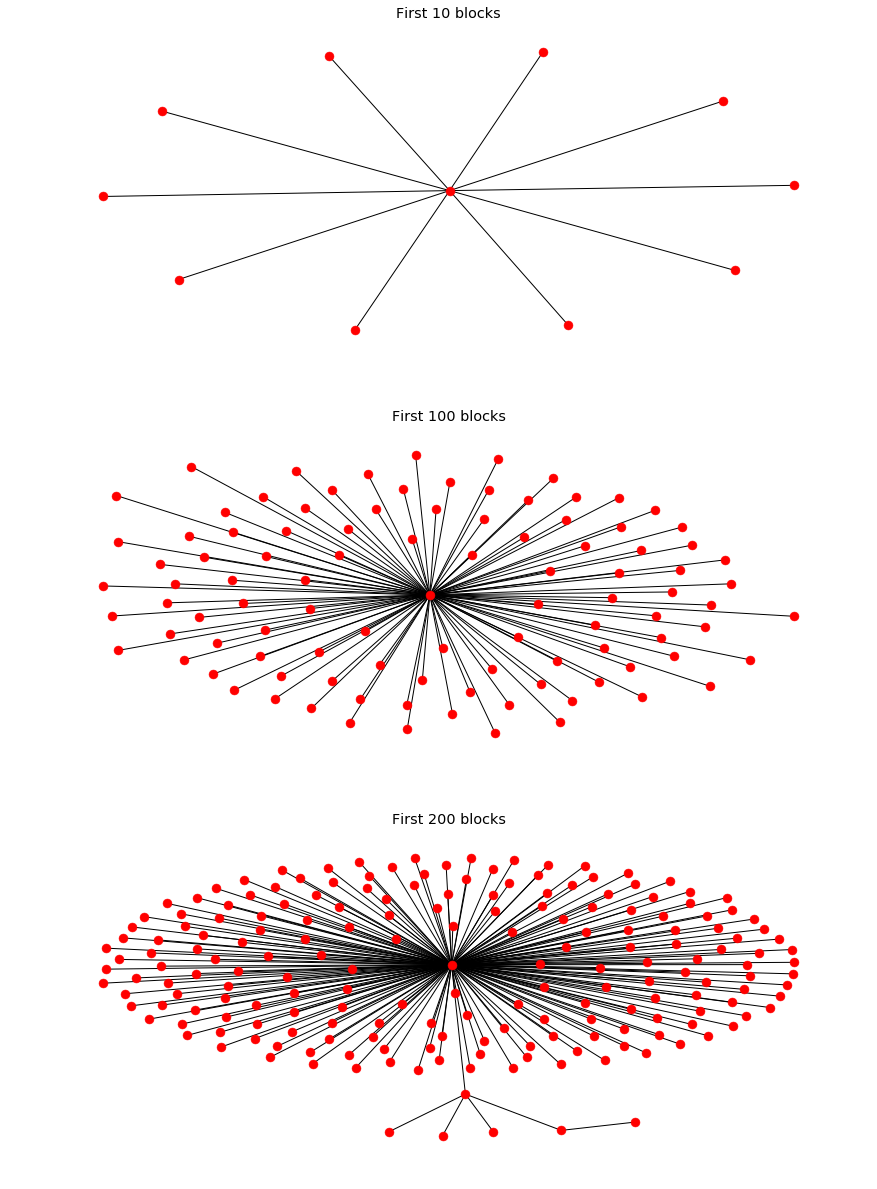

In [136]:
n_blocks = [10, 100, 200]
fig, ax_arr = plt.subplots(len(n_blocks),figsize=(15, len(n_blocks)*7))
for i in range(len(n_blocks)):
    btc_graph = nx.from_pandas_dataframe(graph_df.iloc[:n_blocks[i]], 'addr_from', 'addr_to', 
                                         edge_attr = ['height', 'value','spent_flag'],
                                         create_using=nx.Graph())
    nx.draw_networkx(btc_graph, with_labels=False, node_size = 80, ax=ax_arr[i])

    ax_arr[i].set(title='First {0} blocks'.format(n_blocks[i]))
    ax_arr[i].set_axis_off()


# Create the bitcoin transaction graph and extract key metrics

In [121]:
# Convert transaction graph data frame to edge list
# Edge lists networkx have the form
# to from data_dict

edge_df = graph_df[['addr_from', 'addr_to']]
edge_df['edge_data'] = graph_df[['height', 'value']].to_dict(orient='records')
edge_list = edge_df.values.tolist()
len(edge_list)

/Users/pavel/miniconda3/envs/ra/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


88536

In [122]:
G = nx.MultiDiGraph(edge_list)#[0:90000])
#nx.draw_networkx(G, with_labels=False, node_size = 80)
print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))


Number of nodes: 64222
Number of edges: 88536


In [123]:
# Keep only nodes with valency at least 3
nodes_ge3 = [n for n in G.nodes() if G.in_degree(n) + G.out_degree(n) >=3]
G = G.subgraph(nodes_ge3)
degs_in = G.in_degree()
#print(degs_in, '\n')
degs_out = G.out_degree()
#print(degs_out)
print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 6662
Number of edges: 18561


## Prepare nodes for hiveplot

In [85]:
nx.set_node_attributes(G, "degree_in", degs_in)
nx.set_node_attributes(G, "degree_out", degs_out)
# Assign "pure_miner" flag

In [86]:
#for n, d in G.nodes(data=True):
#    print(n, d)

#nodes['bc_mine'] = [(n,d) for n, d in G.nodes(data=True) if n == "mining"]
#G.node['1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa']["pure_miner"] = True
#G.node['1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa']

# Find transaction recipients
sender_keys = frozenset(np.unique([pub_key for pub_key in graph_df['addr_from'] if pub_key != 'mining']))
#sender_key_mask = graph_df['addr_from'].isin(sender_keys)
miner_addr = frozenset(graph_df.loc[graph_df['addr_from'] == 'mining', 'addr_to'])

#miners = miner_addr#.difference(sender_keys)
#player = sender_keys.difference(pure_miner)

for n in G.nodes_iter():
    if n in miner_addr:
        G.node[n]["miner"] = True
    else:
        G.node[n]["miner"] = False
# Identify nodes that have received mining btc but never sent btc
#sum(np.multiply(miner_mask, ~sender_key_mask))
#pure_miner_keys = graph_df.loc[~graph_df['addr_to'].isin(sender_keys), 'addr_from']

In [87]:
G.node[n]

{'degree_in': 4, 'degree_out': 3, 'miner': False}

In [94]:
nodes = dict()
#nodes['pure_miners'] = [(n,d) for n, d in G.nodes(data=True) if d['miner'] and d['degree_out'] == 0]
#nodes['pure_players'] = [(n,d) for n, d in G.nodes(data=True) if ~d['miner'] and n != 'mining']
nodes['spending_miner'] = [(n,d) for n, d in G.nodes(data=True) if d['miner'] and d['degree_out'] > 0]
nodes['give_and_take_non_miner'] = [(n,d) for n, d in G.nodes(data=True) if not d['miner'] and d['degree_out'] > 0
                         and d['degree_in'] > 0]
nodes['just_take_non_miner'] = [(n,d) for n, d in G.nodes(data=True) if not d['miner'] and d['degree_out'] == 0]
#nodes['players']
for group, nodelist in nodes.items():
    #print(nodelist)
    nodes[group] = sorted(nodelist, key=lambda node: node[1]['degree_out'])
    nodes[group] = [n for n, d in nodes[group]]
print(len(nodes['spending_miner']), len(nodes['give_and_take_non_miner']), len(nodes['just_take_non_miner']))

2777 3567 195


## Prepare edges for hiveplot

In [102]:
edges = dict()
#edges['mining_transaction'] = [(u,v,d) for u,v,d in G.edges(data=True) if u=='mining']
edges['p2p_transaction'] = [(u,v,d) for u,v,d in G.edges(data=True) if u!='mining']
print(len(edges['p2p_transaction']))
# Label self payments
#edges['selfie'] = [(u,v,d) for u,v,d in G.edges(data=True) if u == v]

#print(len(edges['selfie']))
#edges['rest'] = [(u,v,d) for u,v,d in G.edges(data=True) if u != v and u == 'mining']
#print(len(edges['rest']))

15759


## Set color schemes and plot

KeyError: None

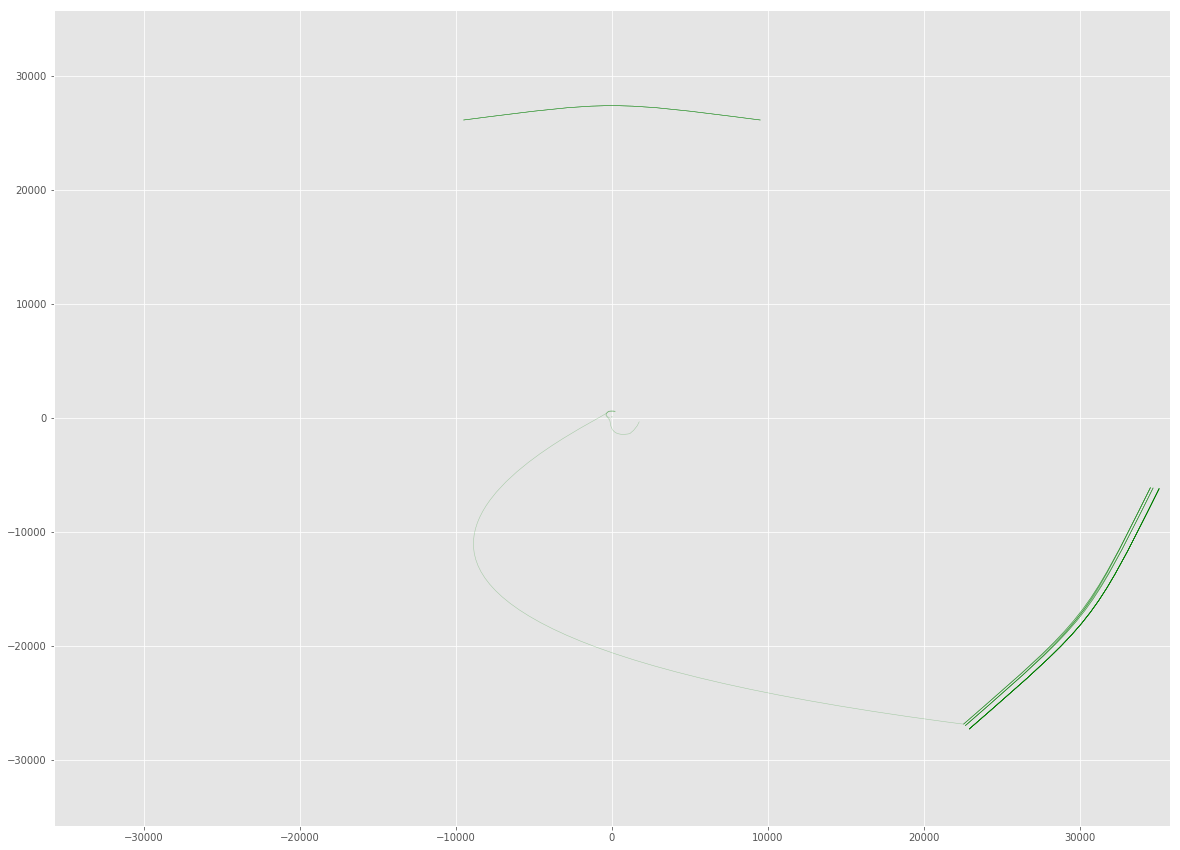

In [103]:
nodes_cmap = dict()
# nodes_cmap['pure_miners'] = 'black'
# nodes_cmap['pure_players'] = 'red'
# nodes_cmap['both'] = 'blue'
nodes_cmap['spending_miner'] = 'black'
nodes_cmap['give_and_take_non_miner'] = 'red'
nodes_cmap['just_take_non_miner'] = 'blue'

edges_cmap = dict()
#edges_cmap['mining_transaction'] = 'green'
edges_cmap['p2p_transaction'] = 'green'
#edges_cmap['selfie'] = 'yellow'
#edges_cmap['rest'] = 'orange'
fig, ax = plt.subplots(figsize=(20, 15))
h = HivePlot(nodes, edges, nodes_cmap, edges_cmap, is_directed=True, fig=fig, ax=ax)
h.draw()

In [606]:
G.node[n]

{'degree_in': 2, 'degree_out': 0, 'miner': False}

## For the remainder remove all mining transactions

In [611]:
# Remove mining transactions and create edge list for node2vec
nodes_no_mine = [n for n in G.nodes() if n != 'miner']
G = G.subgraph(nodes_no_mine)
print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))


Number of nodes: 327
Number of edges: 535


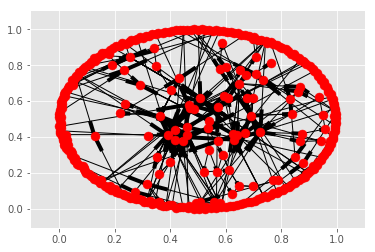

In [612]:
nx.draw_networkx(G, with_labels=False, node_size = 80)

In [620]:
G_n2v = n2v.Graph(G, True,1,2)


In [624]:
#G_n2v.node2vec_walk()

<bound method Graph.node2vec_walk of <node2vec.node2vec.Graph object at 0x13df26668>>

In [160]:
nx.triadic_census(G)

{'003': 1234826,
 '012': 1908,
 '021C': 5,
 '021D': 18151,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}

In [146]:
nodes


{'mining_payments': [('mining', {'degree_in': 0, 'degree_out': 10})],
 'players': [],
 'pure_miners': [('1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa',
   {'degree_in': 1, 'degree_out': 0}),
  ('12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX', {'degree_in': 1, 'degree_out': 0}),
  ('1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1', {'degree_in': 1, 'degree_out': 0}),
  ('1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR', {'degree_in': 1, 'degree_out': 0}),
  ('15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG', {'degree_in': 1, 'degree_out': 0}),
  ('1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu', {'degree_in': 1, 'degree_out': 0}),
  ('1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a', {'degree_in': 1, 'degree_out': 0}),
  ('16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM', {'degree_in': 1, 'degree_out': 0}),
  ('1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj', {'degree_in': 1, 'degree_out': 0}),
  ('12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S', {'degree_in': 1, 'degree_out': 0})]}

In [143]:
nodes

{'mining_payments': [('mining', {'degree_in': 0, 'degree_out': 10})],
 'pure_miners': [('1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa',
   {'degree_in': 1, 'degree_out': 0}),
  ('12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX', {'degree_in': 1, 'degree_out': 0}),
  ('1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1', {'degree_in': 1, 'degree_out': 0}),
  ('1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR', {'degree_in': 1, 'degree_out': 0}),
  ('15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG', {'degree_in': 1, 'degree_out': 0}),
  ('1JfbZRwdDHKZmuiZgYArJZhcuuzuw2HuMu', {'degree_in': 1, 'degree_out': 0}),
  ('1GkQmKAmHtNfnD3LHhTkewJxKHVSta4m2a', {'degree_in': 1, 'degree_out': 0}),
  ('16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM', {'degree_in': 1, 'degree_out': 0}),
  ('1J6PYEzr4CUoGbnXrELyHszoTSz3wCsCaj', {'degree_in': 1, 'degree_out': 0}),
  ('12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S', {'degree_in': 1, 'degree_out': 0})]}